In [1]:
import pyoti.core as coti
import pyoti.sparse as oti
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    "font.size": 12,
    "font.sans-serif": ["Helvetica"]
})

In [7]:
def fun2(X,r,m,b):
    #INTERSECTION BETWEEN CURVES.
    f = oti.zeros((2,1))
    x = X[0,0].copy()
    y = X[1,0].copy()
    f[0,0] = x**2 + y**2 - r**2 
    f[1,0] = y - ( m * x + b )
    return f

def fun2_curves(x,r,m,b):
    #CURVES.
    y = oti.zeros((x.shape[0],3))
    y[:,0] =  oti.sqrt(r**2 - x**2)
    y[:,1] = -oti.sqrt(r**2 - x**2)
    y[:,2] = m * x + b
    return y


def intersect_pts(r,m,b,alg=oti):
    #CURVES.
        
    #     x[0,0] = (-m*b + oti.sqrt( (m*b)**2 - (m+1)*(b**2-r**2) ) )/( (m+1) )
    #     x[1,0] = (-m*b - oti.sqrt( (m*b)**2 - (m+1)*(b**2-r**2) ) )/( (m+1) )

    x1 = (-b*m + alg.sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)
    y1 = m * x1 + b
    x2 = (-b*m - alg.sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)
    y2 = m * x2 + b
    

    
    return x1,y1,x2,y2

In [3]:
# utils
def newton_otisis(func, jaco, x, tol, maxiter=50, args=()):
    error = 1e30
    n = 0
    nx = x.shape[0]
    dx = oti.zeros( (nx,1), order=x.order)
    argv = (func,)+args
    while error > tol:
        if n==maxiter:
            print("Did not converge. ", maxiter, "iters.")
            break
        mJ = -jaco(x,*argv)
#         print(mJ.shape)
        f_eval = func(x,*args)
#         print(f_eval.shape)
        dx = oti.dot(oti.inv(mJ),f_eval)
        error = oti.norm(dx).get_deriv(0)        
        x += dx
        n += 1
    print("niter: ",n)
#     print("rel_err:",(oti.norm(dx)/oti.norm(x)).get_deriv(0))
    return x

def j_DF (x, func, *args):
    h = 1e-8
    nx = x.shape[0]
    J = oti.zeros((nx,nx), order=x.order)
    for i in range(nx):
        xh = x.copy()
        xh[i,0]+= h
        dfdxi = (func(xh,*args) - func(x,*args))/h
        for j in range(nx):
            J[j,i] = dfdxi[j,0]
    return J

def j_oti (x, func, *args):
    nx = x.shape[0]
    active_bases = func(x,*args).get_active_bases()
    if len(active_bases)==0:
        next_base = 1 
    else:
        next_base = max(active_bases) + 1
    # end if 
    
    e_x = oti.zeros((nx,1), order=x.order)
    for i in range(nx):
        e_x[i] = oti.e(next_base + i)  
    # end for 
    J = oti.zeros((nx,nx), order=x.order)
    fun = func(x+e_x, *args) 
    for n in range(nx):
        J_col = fun.extract_deriv(next_base + n)
        for j in range(nx):
            J_col = J_col.truncate(next_base + j)
        # end for 
        for m in range(nx):
            J[m,n] = J_col[m,0]
        # end for 
    # end for 
    return J

In [4]:
order = 20
x0 = oti.array([1,1])
r  = 4+oti.e(1, order = order)
m  = 3+oti.e(2, order = order)
b = -4+oti.e(3, order = order)

In [5]:
X = newton_otisis(fun2,j_oti,x0,1e-8, args = (r,m,b))

niter:  6


In [6]:
# Compute the analytoc intersection points.
x_int, y_int,x2_int, y2_int = intersect_pts(r,m,b)
print(x_int.real,y_int.real)

2.4000000000000004 3.200000000000001


<IPython.core.display.Javascript object>


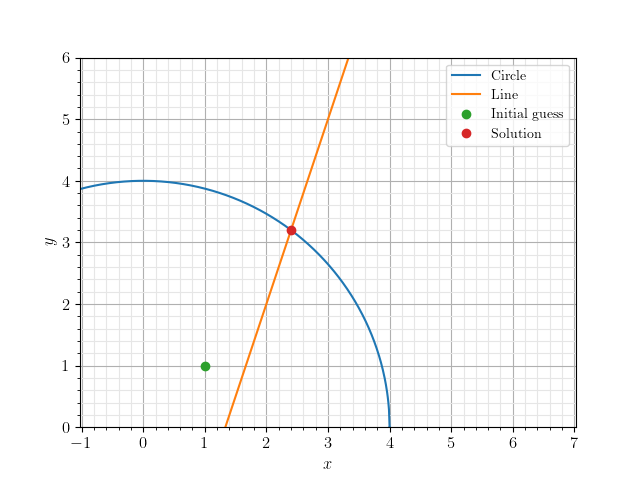

In [7]:
# Plot the system
plt.figure()

d = r.real+2
x_plot_r = np.arange(-d,d,0.01)
x_plot   = oti.array(x_plot_r)

Y = fun2_curves(x_plot,r.real,m.real,b.real)
y_circ_up= Y[:,0]
y_circ_dn= Y[:,1]
y_line   = Y[:,2]

plt.plot(x_plot_r,y_circ_up.real,c='C0',label='Circle')
plt.plot(x_plot_r,y_circ_dn.real,c='C0')

plt.plot(x_plot_r,y_line.real   ,c='C1',label='Line')




# plt.plot(x_int.real,y_int.real,'.', c='C2', label='Intersection')

plt.plot(x0[0].real ,x0[1].real ,'o', c='C2', label='Initial guess')
plt.plot(X[0].real ,X[1].real ,'o', c='C3', label='Solution')


plt.axis('equal')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.legend(fontsize=10)

plt.axis([0,d,0,d])
plt.grid()
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.xlabel('$x$')
plt.ylabel('$y$')


plt.savefig("pdf/line-circ-intersect.pdf",dpi=150)
plt.show()

In [8]:
Δr = 0.0
Δm = -2.0
Δb = 0.0
m

3.0000 + 1.0000 * e([2])

<IPython.core.display.Javascript object>


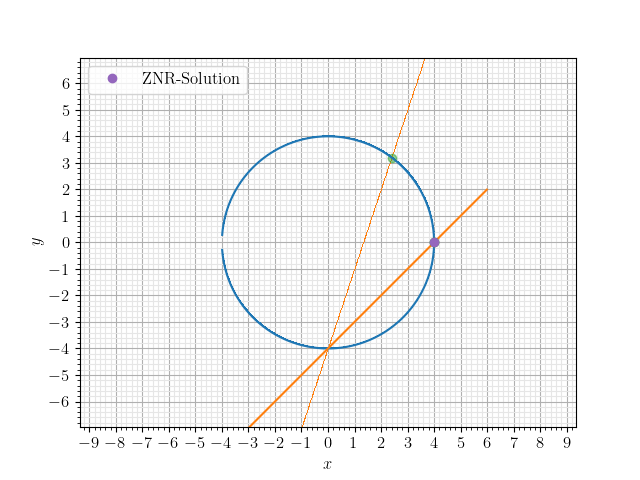

In [9]:
rnew = r.rom_eval([1,2,3],[Δr,Δm,Δb])
mnew = m.rom_eval([1,2,3],[Δr,Δm,Δb])
bnew = b.rom_eval([1,2,3],[Δr,Δm,Δb])
Xnew = X.rom_eval([1,2,3],[Δr,Δm,Δb])

# Plot the system
plt.figure()

d = r.real+2
x_plot_r = np.arange(-d,d,0.01)
x_plot   = oti.array(x_plot_r)

Y = fun2_curves(x_plot,r.real,m.real,b.real)
y_circ_up= Y[:,0]
y_circ_dn= Y[:,1]
y_line   = Y[:,2]

plt.plot(x_plot_r,y_circ_up.real,',',c='C0',ms=5)
plt.plot(x_plot_r,y_circ_dn.real,',',c='C0',ms=5)

plt.plot(x_plot_r,y_line.real  ,',' ,c='C1')

plt.plot(x_int.real,y_int.real , 'o' ,c='C2',alpha=0.5)

Y = fun2_curves(x_plot,rnew.real,mnew.real,bnew.real)
y_circ_up= Y[:,0]
y_circ_dn= Y[:,1]
y_line   = Y[:,2]

plt.plot(x_plot_r,y_circ_up.real,'-',c='C0')
plt.plot(x_plot_r,y_circ_dn.real,'-',c='C0')

plt.plot(x_plot_r,y_line.real   ,'-',c='C1')

x_intnew, y_intnew,x2_intnew, y2_intnew = intersect_pts(rnew,mnew,bnew)
plt.plot(x_intnew.real,y_intnew.real , 'o' ,c='C2')
# plt.plot(x2_intnew.real,y2_intnew.real , 'o' ,c='C3')

plt.plot(Xnew[0].real ,Xnew[1].real ,'o', c='C4', label='ZNR-Solution')


plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
ax = plt.gca()

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

eps = r.real*1.2
plt.axis([-eps,eps,-eps,eps])
plt.grid()
plt.legend()
plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.savefig("pdf/line-circ-intersect-newsol.pdf",dpi=150)
plt.show()

In [10]:
b

-4.0000 + 1.0000 * e([3])

In [11]:
r_plot = oti.array(np.linspace(1.5,r.real+20,500))
oti.sqrt(r_plot**2)

matso< shape: (500, 1), 
 - Column 0
(0,0) 1.5
(1,0) 1.54509
(2,0) 1.59018
(3,0) 1.63527
(4,0) 1.68036
(5,0) 1.72545
(6,0) 1.77054
(7,0) 1.81563
(8,0) 1.86072
(9,0) 1.90581
(10,0) 1.9509
(11,0) 1.99599
(12,0) 2.04108
(13,0) 2.08617
(14,0) 2.13126
(15,0) 2.17635
(16,0) 2.22144
(17,0) 2.26653
(18,0) 2.31162
(19,0) 2.35671
(20,0) 2.4018
(21,0) 2.44689
(22,0) 2.49198
(23,0) 2.53707
(24,0) 2.58216
(25,0) 2.62725
(26,0) 2.67234
(27,0) 2.71743
(28,0) 2.76253
(29,0) 2.80762
(30,0) 2.85271
(31,0) 2.8978
(32,0) 2.94289
(33,0) 2.98798
(34,0) 3.03307
(35,0) 3.07816
(36,0) 3.12325
(37,0) 3.16834
(38,0) 3.21343
(39,0) 3.25852
(40,0) 3.30361
(41,0) 3.3487
(42,0) 3.39379
(43,0) 3.43888
(44,0) 3.48397
(45,0) 3.52906
(46,0) 3.57415
(47,0) 3.61924
(48,0) 3.66433
(49,0) 3.70942
(50,0) 3.75451
(51,0) 3.7996
(52,0) 3.84469
(53,0) 3.88978
(54,0) 3.93487
(55,0) 3.97996
(56,0) 4.02505
(57,0) 4.07014
(58,0) 4.11523
(59,0) 4.16032
(60,0) 4.20541
(61,0) 4.2505
(62,0) 4.29559
(63,0) 4.34068
(64,0) 4.38577
(65,0) 4

In [13]:
#intersect_pts( r_plot, m, b)

<ipython-input-7-ad76e43cd6f3>:25: RuntimeWarning: invalid value encountered in sqrt
  x1 = (-b*m + alg.sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)
<ipython-input-7-ad76e43cd6f3>:27: RuntimeWarning: invalid value encountered in sqrt
  x2 = (-b*m - alg.sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)


<IPython.core.display.Javascript object>


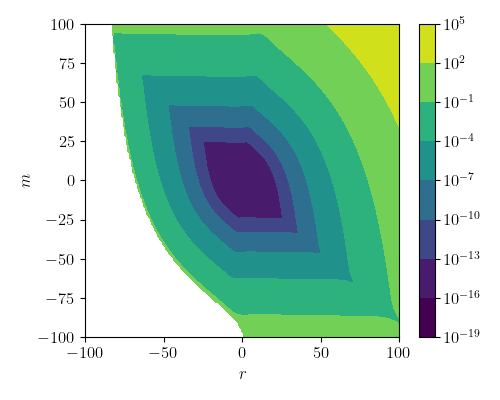

In [17]:
dr = np.linspace((-r).real,(r).real,200)
dm = np.linspace((-m).real,(m).real,200)

dR,dM = np.meshgrid(dr,dm)
x_sol = X[0,0]
y_sol = X[1,0]

Xeval = x_sol.rom_eval_object([1,2,3],[dR,dM,0])
Yeval = y_sol.rom_eval_object([1,2,3],[dR,dM,0])

Xexact,Yexact, _, _ = intersect_pts( r.real+dR, m.real+dM, b.real ,alg=np)

err = np.sqrt((Xeval-Xexact)**2 + (Yeval-Yexact)**2)+1e-16

errEstX = Xeval.truncate_order(6)-Xeval.truncate_order(5)
errEstY = Yeval.truncate_order(6)-Yeval.truncate_order(5)

errEstX.rom_eval_object([1,2,3],[dR,dM,0])
errEstY.rom_eval_object([1,2,3],[dR,dM,0])
errEst = 
# err = np.ma.masked_where(err <= 1e-13, err)


fig = plt.figure(figsize=(5,4))

cs = plt.contourf(100*dR/r.real, 100*dM/m.real, err, locator=ticker.LogLocator(), vmin=1e-16)

plt.xlabel('$r$')
plt.ylabel('$m$')
fig.colorbar(cs)
plt.tight_layout()

plt.show()

In [30]:
r_plot = oti.array( np.linspace(1.5,r.real+20,500) )

dr = np.linspace((-r).real,(r).real,200)
dm = np.linspace((-m).real,(m).real,200)

dRnp,dMnp = np.meshgrid(dr,dm)
dR = oti.array(dRnp)
dM = oti.array(dMnp)


# x_intanalyt, y_intanalyt = intersect_eval(r_plot,m.real,b.real)
x_intanalyt, y_intanalyt, x2_intanalyt, y2_intanalyt = intersect_pts( dR, dM, b )

# plt.figure(figsize=(5,4))

# plt.title('$x_i(r)$')
# plt.plot(r_plot.real,x_intanalyt.real,'-',c='C0',lw=2)

# # Get the TSE behavior.
# x_oti = X[0,0]
# xnew_eval = np.zeros_like(r_plot.real)
# ordi = 30
# for i in range(r_plot.size):
#     x_oti_eval = x_oti.truncate([[1,ordi+1]])
# #     print( x_oti_eval.rom_eval([1,2,3],[(r_plot[i,0]-r).real,0,0]).real)
#     xnew_eval[i] = x_oti_eval.rom_eval([1,2,3],[(r_plot[i,0]-r).real,0,0]).real

# plt.plot(r_plot.real,xnew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

# plt.plot(r.real,X[0,0].real,'o',c='C2',ms=10,label='Evaluation point r={0:.1f}'.format(r.real))

# # plt.axis('equal')
# plt.xlabel('b')
# plt.ylabel('$x_i$')
# ax = plt.gca()

# # ax.xaxis.set_major_locator(MultipleLocator(1))
# # ax.yaxis.set_major_locator(MultipleLocator(1))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

# plt.grid(which='minor', color=(0.9,0.9,0.9))

# plt.axis([None,None,1.1,10])
# plt.grid()
# plt.legend(fontsize=10)
# plt.tight_layout()

# plt.show()



In [ ]:
r_plot = oti.array( np.linspace(1.5,r.real+20,500) )
# x_intanalyt, y_intanalyt = intersect_eval(r_plot,m.real,b.real)
x_intanalyt, y_intanalyt, x2_intanalyt, y2_intanalyt = intersect_pts( r_plot, m, b)


plt.figure(figsize=(5,4))

plt.title('$x_i(r)$')
plt.plot(r_plot.real,x_intanalyt.real,'-',c='C0',lw=2)

# Get the TSE behavior.
x_oti = X[0,0]
xnew_eval = np.zeros_like(r_plot.real)
ordi = 30
for i in range(r_plot.size):
    x_oti_eval = x_oti.truncate([[1,ordi+1]])
#     print( x_oti_eval.rom_eval([1,2,3],[(r_plot[i,0]-r).real,0,0]).real)
    xnew_eval[i] = x_oti_eval.rom_eval([1,2,3],[(r_plot[i,0]-r).real,0,0]).real

plt.plot(r_plot.real,xnew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

plt.plot(r.real,X[0,0].real,'o',c='C2',ms=10,label='Evaluation point r={0:.1f}'.format(r.real))

# plt.axis('equal')
plt.xlabel('b')
plt.ylabel('$x_i$')
ax = plt.gca()

# ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.axis([None,None,1.1,10])
plt.grid()
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


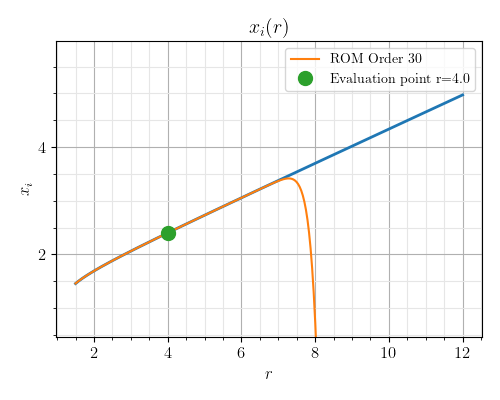

In [29]:

r_plot = np.linspace(1.5,r.real+8,500)
x_intanalyt, y_intanalyt = intersect_eval(r_plot,m.real,b.real)


plt.figure(figsize=(5,4))

plt.title('$x_i(r)$')
plt.plot(r_plot,x_intanalyt,'-',c='C0',lw=2)

# Get the TSE behavior.
x_oti = X[0,0]
xnew_eval = np.zeros_like(r_plot)
ordi = 30
for i in range(r_plot.size):
    x_oti_eval = x_oti.truncate([[1,ordi+1]])
    xnew_eval[i] = x_oti_eval.rom_eval([1,2,3],[r_plot[i]-r.real,0,0]).real

plt.plot(r_plot,xnew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

plt.plot(r.real,X[0,0].real,'o',c='C2',ms=10,label='Evaluation point r={0:.1f}'.format(r.real))

# plt.axis('equal')
plt.xlabel('$r$')
plt.ylabel('$x_i$')
ax = plt.gca()

# ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(1))

plt.axis([
    None,None,
    min(x_intanalyt[~np.isnan(x_intanalyt)])-1,
    max(x_intanalyt[~np.isnan(x_intanalyt)])+1])
plt.grid()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()


<IPython.core.display.Javascript object>


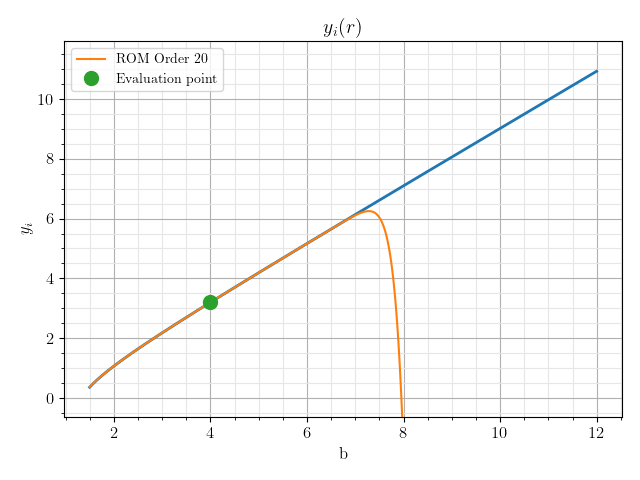

In [27]:
plt.figure()

plt.title('$y_i(r)$')
plt.plot(r_plot,y_intanalyt,'-',c='C0',lw=2)

# Get the TSE behavior.
y_oti = X[1,0]
ynew_eval = np.zeros_like(r_plot)
ordi = 20
for i in range(r_plot.size):
    y_oti_eval = y_oti.truncate([[1,ordi+1]])
    ynew_eval[i] = y_oti_eval.rom_eval([1,2,3],[r_plot[i]-r.real,0,0]).real

plt.plot(r_plot,ynew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

plt.plot(r.real,X[1,0].real,'o',c='C2',ms=10,label='Evaluation point')

# plt.axis('equal')
plt.xlabel('b')
plt.ylabel('$y_i$')
ax = plt.gca()

# ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(1))

plt.axis([
    None,None,
    min(y_intanalyt[~np.isnan(y_intanalyt)])-1,
    max(y_intanalyt[~np.isnan(y_intanalyt)])+1])


ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.grid()
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


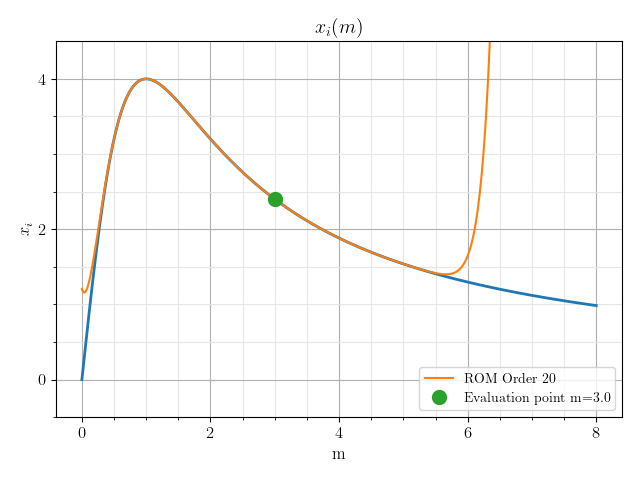

In [28]:
m_plot = np.linspace(0,m.real+5,500)
x_intanalyt, y_intanalyt = intersect_eval(r.real,m_plot,b.real)


plt.figure()

plt.title('$x_i(m)$')
plt.plot(m_plot,x_intanalyt,'-',c='C0',lw=2)

# Get the TSE behavior.
x_oti = X[0,0]
xnew_eval = np.zeros_like(m_plot)
ordi = 20
for i in range(m_plot.size):
    x_oti_eval = x_oti.truncate([[2,ordi+1]])
    xnew_eval[i] = x_oti_eval.rom_eval([1,2,3],[0,m_plot[i]-m.real,0]).real

plt.plot(m_plot,xnew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

plt.plot(m.real,X[0,0].real,'o',c='C2',ms=10,label='Evaluation point m={0:.1f}'.format(m.real))

# plt.axis('equal')
plt.xlabel('m')
plt.ylabel('$x_i$')
ax = plt.gca()

plt.axis([
    None,None,
    min(x_intanalyt[~np.isnan(x_intanalyt)])-.5,
    max(x_intanalyt[~np.isnan(x_intanalyt)])+.5])
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.grid()
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.legend(fontsize=10)
plt.tight_layout()


plt.show()



<IPython.core.display.Javascript object>


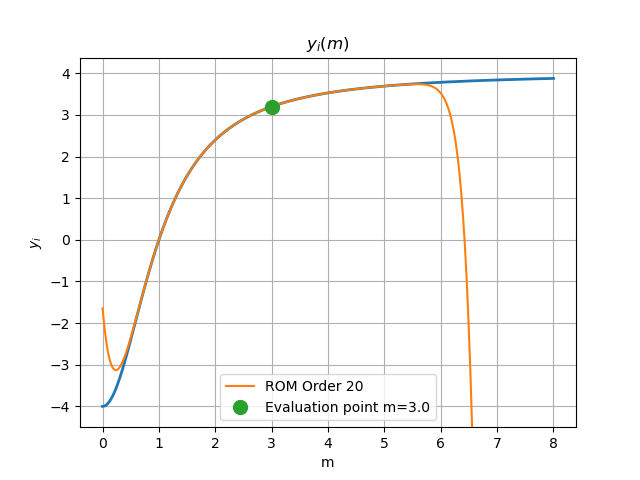

In [36]:
plt.figure()

plt.title('$y_i(m)$')
plt.plot(m_plot,y_intanalyt,'-',c='C0',lw=2)

# Get the TSE behavior.
y_oti = X[1,0]
ynew_eval = np.zeros_like(m_plot)
ordi = 20
for i in range(m_plot.size):
    y_oti_eval = y_oti.truncate([[2,ordi+1]])
    ynew_eval[i] = y_oti_eval.rom_eval([1,2,3],[0,m_plot[i]-m.real,0]).real

plt.plot(m_plot,ynew_eval,'-',c='C1',ms=5,label='ROM Order '+str(ordi))

plt.plot(m.real,X[1,0].real,'o',c='C2',ms=10,label='Evaluation point m={0:.1f}'.format(m.real))

# plt.axis('equal')
plt.xlabel('m')
plt.ylabel('$y_i$')
ax = plt.gca()

# ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(1))


plt.grid()
plt.legend()

plt.axis([
    None,None,
    min(y_intanalyt[~np.isnan(y_intanalyt)])-.5,
    max(y_intanalyt[~np.isnan(y_intanalyt)])+.5])

plt.show()




In [37]:
deriv = [[2,1]]
print(x_int[0,0].get_deriv(deriv))
print(y_int[0,0].get_deriv(deriv))

-0.6399999999999999
0.48000000000000065


In [38]:
Xder = X.get_deriv(deriv)
print(Xder[0,0])
print(Xder[1,0])

-0.64
0.48


In [12]:
x_int[0,0].rom_eval([1,2,3],[Δr,Δm,Δb])

2.1025

In [13]:
X[0,0].rom_eval([1,2,3],[Δr,Δm,Δb])

2.1025

In [14]:
x0[0,0]

1.0000

In [17]:
fun2(X,r,m,b).real

array([[ 0.00000000e+00],
       [-3.33066907e-16]])

In [18]:
fun2(Xnew,rnew,mnew,bnew)

matso< shape: (2, 1), 
 - Column 0
(0,0) -0.120481
(1,0) 1.33227e-15
>

In [13]:
import sympy as sym

In [14]:
xs,ms,bs,rs = sym.symbols('x m b r')

In [15]:
ys = ms*xs+bs
ys

b + m*x

In [16]:
fs= xs**2+ys**2-rs**2
fs.expand()

b**2 + 2*b*m*x + m**2*x**2 - r**2 + x**2

In [17]:
xs_int,xs2_int =sym.solve(fs,xs)

In [18]:
xs_int

(-b*m + sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)

In [19]:
xs2_int

-(b*m + sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)

In [20]:
ys_int = ms*xs_int + bs

ys_int.expand().doit().factor()

(b + m*sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)

In [21]:
ys2_int = ms*xs2_int + bs

ys2_int.expand().doit().factor()

(b - m*sqrt(-b**2 + m**2*r**2 + r**2))/(m**2 + 1)

In [19]:
d1xm = xs_int.diff(ms,1)
d1ym = ys_int.diff(ms,1)

d2xm = xs_int.diff(ms,2)
d2ym = ys_int.diff(ms,2)

d3xm = xs_int.diff(ms,3)
d3ym = ys_int.diff(ms,3)

d4xm = xs_int.diff(ms,4)
d4ym = ys_int.diff(ms,4)

d10xm = xs_int.diff(ms,10)
d10ym = ys_int.diff(ms,10)

d20xm = xs_int.diff(ms,20)
d20ym = ys_int.diff(ms,20)

In [20]:
d1xm.subs(dict(r=r.real,m=m.real,b=b.real)),d1ym.subs(dict(r=r.real,m=m.real,b=b.real))

(-0.684018778721877, 0.609838667696594)

In [21]:
d2xm.subs(dict(r=r.real,m=m.real,b=b.real)),d2ym.subs(dict(r=r.real,m=m.real,b=b.real))

(0.279263128725020, -0.530248171268695)

In [22]:
d4xm.subs(dict(r=r.real,m=m.real,b=b.real)),d4ym.subs(dict(r=r.real,m=m.real,b=b.real))

(-0.151332540409449, -0.783877351249161)

In [23]:
d10xm.subs(dict(r=r.real,m=m.real,b=b.real)),d10ym.subs(dict(r=r.real,m=m.real,b=b.real))


(-156.740454471425, 23.9830251804654)

In [24]:
d20xm.subs(dict(r=r.real,m=m.real,b=b.real)),d20ym.subs(dict(r=r.real,m=m.real,b=b.real))

(-2940933900.62463, -2389550442.93668)

In [19]:
X.get_deriv([[2,20]])

array([[-2.94093390e+09],
       [-2.38955044e+09]])

In [22]:
from sympy.utilities.lambdify import lambdify

In [23]:
intersect_eval = lambdify([rs,ms,bs],[xs_int,ys_int])

In [179]:
# 20th order derivatives w.r.t. 3 vars.
h = coti.get_dHelp()
h.get_ndir_total(3,20)

1771